In [1]:
import os
from google.cloud import storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gs
import collections
import scipy.stats
import random
from collections import OrderedDict
from signatureanalyzer import plotting
import seaborn as sns
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import math
import re

In [2]:
META = ['q_val', 'q_val_rht', 'significance']

annotations = pd.read_csv('./comut_annotations.tsv', sep='\t')
annotations.index = annotations['Patient IDs']

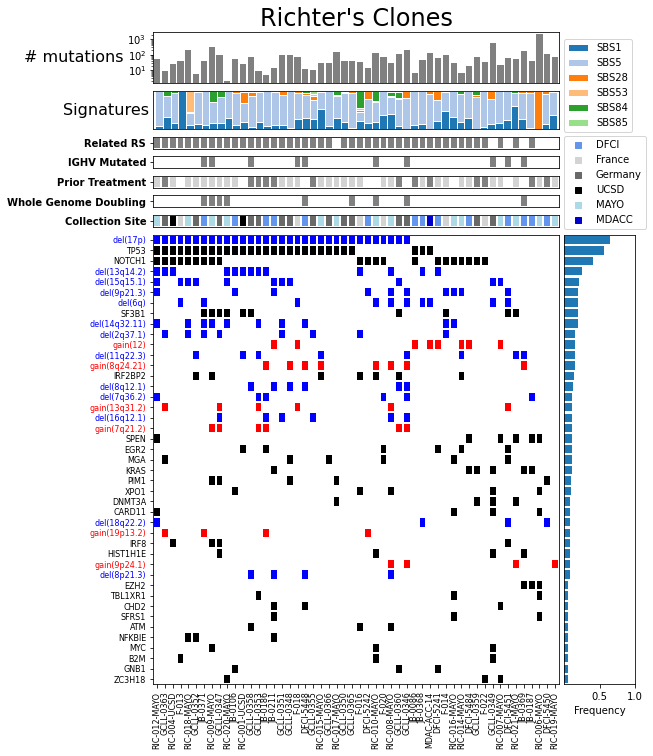

In [6]:
# RS History plotting
fig = plt.figure(figsize=(10, 12))
spec = gs.GridSpec(ncols=1100, nrows=100, figure=fig)

plot_bound = 800

rate_ax = fig.add_subplot(spec[:8, 150:950])
sig_ax = fig.add_subplot(spec[9:15, 150:950])
related_ax = fig.add_subplot(spec[16:18, 150:950])
mutated_ax = fig.add_subplot(spec[19:21, 150:950])
prior_ax = fig.add_subplot(spec[22:24, 150:950])
wgd_ax = fig.add_subplot(spec[25:27, 150:950])
site_ax = fig.add_subplot(spec[28:30, 150:950])
main_ax = fig.add_subplot(spec[31:, 150:950])
freq_ax = fig.add_subplot(spec[31:, 960:])  #(spec[30:, :140])

# plot clonal related vs unrelated Richters
related_ax.set_xticks([])
related_ax.set_xlim(0, 52)
related_ax.set_yticks([0.5])
related_ax.set_yticklabels(['Related RS'], fontweight='bold')

# plot mutated vs unmutated CLL
mutated_ax.set_xticks([])
mutated_ax.set_xlim(0, 52)
mutated_ax.set_yticks([0.5])
mutated_ax.set_yticklabels(['IGHV Mutated'], fontweight='bold')

# plot prior therapeutic treatments
prior_ax.set_xticks([])
prior_ax.set_xlim(0, 52)
prior_ax.set_yticks([0.5])
prior_ax.set_yticklabels(['Prior Treatment'], fontweight='bold')

# plot whole genome doubling
wgd_ax.set_xticks([])
wgd_ax.set_xlim(0, 52)
wgd_ax.set_yticks([0.5])
wgd_ax.set_yticklabels(['Whole Genome Doubling'], fontweight='bold')

site_ax.set_xticks([])
site_ax.set_xlim(0, 52)
site_ax.set_yticks([0.5])
site_ax.set_yticklabels(['Collection Site'], fontweight='bold')

# plot mutations for main body of CoMut
events = pd.read_csv('./rs_history_forcecalling/richters_history_forcecall_FINAL.tsv', sep='\t', index_col=0)
# events = pd.read_csv('./rs_only_forcecalling/richters_only_forcecall_FINAL.tsv', sep='\t', index_col=0)

# events.sort_values('q_val', ascending=False, axis=0, inplace=True)
events.replace([2.0, 3.0], 1.0, inplace=True)
events['frequency'] = events.sum(axis=1) / 52.0
events.sort_values('frequency', axis=0, inplace=True)

sort_order = events.index.tolist()
sort_order.reverse()

events_only = events.copy()
try:
    events_only.drop(columns=['q_val', 'q_val_rht', 'frequency'], inplace=True)
except KeyError:
    events_only.drop(columns=['frequency'], inplace=True)
    
events_only.sort_values(sort_order, axis=1, ascending=False, inplace=True)

events.replace([2.0, 3.0], 1.0, inplace=True)
events_only = events_only[pt_order]

main_ax.set_xlim(0, len(events_only.columns))
main_ax.set_ylim(0, len(events_only.index))

main_ax.set_yticks(np.arange(len(events_only.index)) + 0.5)
main_ax.set_yticklabels(events_only.index.tolist(), fontsize=8)

labels = main_ax.get_yticklabels()

for label in labels:
    if label.get_text().startswith('del'):
        label.set_color("blue")
    elif label.get_text().startswith('gain'):
        label.set_color("red")
    else:
        label.set_color("black")

main_ax.set_xticks(np.arange(len(events_only.columns)) + .5)
main_ax.set_xticklabels(events_only.columns, fontsize=8, rotation=90, ha='center')

for i in range(len(events_only.index)):
    color = labels[i].get_color()
    for j in range(len(events_only.columns)):
        if events_only.iloc[i][j] > 0:
            
            p = patches.Rectangle((j, i), 1, 1, fill=True, facecolor=color, linestyle='-', edgecolor='#FFFFFF',
                          linewidth=2)
            main_ax.add_patch(p)

# plot frequency in horizontal bar plot
freq_ax.set_ylim(0, len(events_only.index))
freq_ax.set_yticks(np.arange(len(events_only.index)) + 0.5)
freq_ax.set_yticklabels(events_only.index)
freq_ax.set_yticks([])
freq_ax.set_yticklabels([])


freq_ax.set_xlim(0, 1)
freq_ax.set_xticks([0.5, 1.0])
# freq_ax.set_xscale('linear')
freq_ax.set_xlabel('Frequency')
# freq_ax.invert_xaxis()
y_pos = np.arange(len(events.frequency)) + 0.5
freq_ax.barh(y_pos, events.frequency, align='center')

# plot mutation rate
rates = pd.read_csv('./RT_all_tr_all_RS_clones_subclones_9_21_21.maf', sep='\t').Patient_ID.value_counts()
rates = rates[events_only.columns]
rate_ax.bar(np.arange(52) + .5, rates, color='gray') # Plot mutation rate
rate_ax.set_ylabel('# mutations', x=5, y=.5, rotation='horizontal', fontsize=16, ha='right', va='center')
rate_ax.set_xlim(0, len(events_only.columns))
# rate_ax.set_ylim(0, 2000)
rate_ax.set_xticks([])
# rate_ax.set_yticks([0, 2000])
# rate_ax.set_yticklabels(['0', '2000+'], va='center_baseline')
rate_ax.set_title('Richter\'s Clones', fontsize=24)
rate_ax.set_yscale('log')

site_dict = {'DFCI' : 'cornflowerblue',
            'France': 'lightgray',
            'Germany': 'dimgray',
            'UCSD': 'black',
            'MAYO': 'lightblue',
            'MDACC': 'mediumblue'}

# plot rectangle for related, mutated, and prior therapy
x_pos = 0
for patient in events_only.columns:
    
    # Plot rectangles for clonal relatedness
    color = 'gray' if pd.isna(annotations.loc[patient, 'Clonal unrelated?']) else 'white'
    p = patches.Rectangle((x_pos, 0), 1, 1, fill=True, facecolor=color, linestyle='-', edgecolor='#FFFFFF',
                          linewidth=2)
    related_ax.add_patch(p)
    
    # Plot rectangles for IGHV mutational status
    color = 'gray' if annotations.loc[patient, 'IGHV mutational status'] == 'M' else 'white'
    p = patches.Rectangle((x_pos, 0), 1, 1, fill=True, facecolor=color, linestyle='-', edgecolor='#FFFFFF',
                          linewidth=2)
    mutated_ax.add_patch(p)
    
    # Plot rectangles to indicate prior treatment lines on CLL
    color_dict = {'0': 'white', '1': 'lightgrey', '2':'grey'}
    label_dict = {'0': 'No prior therapy', '1': 'Chemo only', '2': 'Targeted agent therapy'}
    
    prior_tmnt = annotations.loc[patient, 'type of prior therapies for CLL']
        
    p = patches.Rectangle((x_pos, 0), 1, 1, fill=True, facecolor=color_dict[prior_tmnt], linestyle='-', edgecolor='#FFFFFF',
                          linewidth=2, label=label_dict[prior_tmnt])
    prior_ax.add_patch(p)
    
    # Plot rectangles for WGD
    color = 'white' if pd.isna(annotations.loc[patient, 'WGD']) else 'gray'
    p = patches.Rectangle((x_pos, 0), 1, 1, fill=True, facecolor=color, linestyle='-', edgecolor='#FFFFFF',
                          linewidth=2)
    wgd_ax.add_patch(p)
    
    # Plot rectangles for collection site
    
    color = site_dict[annotations.loc[patient, 'collection_site']]
    p = patches.Rectangle((x_pos, 0), 1, 1, fill=True, facecolor=color, linestyle='-', edgecolor='#FFFFFF',
                          linewidth=2)
    site_ax.add_patch(p)
    
    x_pos +=1
    
# plot signatures by patient
H_clust = pd.read_hdf('../../sig_analysis_wes_wgs/sig_analysis_wes_wgs_supercleaned_unclustered_patients_semisupervised/nmf_output.h5', "H")
H_clust = pd.read_csv('./supervised_H', sep='\t')
H_clust.index = H_clust['sample']
H_clust = H_clust.drop(columns=['sample'])
H_clust = H_clust.iloc[:,:-3].copy()

# formatting data
for row in H_clust.index:
    if row.startswith('SBS'):
        H_clust = H_clust.drop([row])

H_clust['sum'] = H_clust.sum(1)

H_norm = H_clust.iloc[:,:-1].div(H_clust['sum'].values,axis=0)
H_norm.columns = H_norm.columns.str[3:]
H_norm = H_norm.reindex(sorted(H_norm.columns, key=lambda x: int(re.sub('[^0-9]','', x))), axis=1)
H_norm = H_norm.loc[events_only.columns]

colors = sns.color_palette("tab20", n_colors=len(H_norm.columns))
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

H_norm.plot(
        kind='bar',
        stacked=True,
        ax=sig_ax,
        width=1.0,
        rasterized=True,
        linestyle='-',
        edgecolor='white',
        colormap=cmap1)

sig_ax.set_ylabel('Signatures', x=-4, y=.5, rotation='horizontal', fontsize=16, ha='right', verticalalignment='center')
sig_ax.set_xticks([])
sig_ax.set_yticks([])
sig_ax.legend(bbox_to_anchor=(1.00,2.5), loc="upper left")

# The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='s', linestyle='') for color in site_dict.values()]
site_ax.legend(markers, site_dict.keys(), numpoints=1, bbox_to_anchor=(1.00,8), loc="upper left")

In [ ]:
fig.savefig('./richters_only_comut_FINAL.pdf', dpi=900, format='pdf', metadata=None, bbox_inches='tight')

In [5]:
pt_order = ['RIC-012-MAYO',
 'GCLL-0363',
 'RIC-004-UCSD',
 'F-013',
 'RIC-018-MAYO',
 'GCLL-0352',
 'JB-0371',
 'RIC-009-MAYO',
 'GCLL-0347',
 'RIC-020-MAYO',
 'JB-0106',
 'RIC-001-UCSD',
 'GCLL-0358',
 'GCLL-0353',
 'JB-0186',
 'JB-0211',
 'GCLL-0351',
 'GCLL-0348',
 'F-018',
 'DFCI-5448',
 'GCLL-0355',
 'RIC-015-MAYO',
 'GCLL-0366',
 'RIC-017-MAYO',
 'GCLL-0350',
 'GCLL-0365',
 'F-016',
 'DFCI-5242',
 'RIC-010-MAYO',
 'F-020',
 'RIC-008-MAYO',
 'GCLL-0360',
 'GCLL-0346',
 'JB-0086',
 'JB-0368',
 'MDAC-ACC-14',
 'DFCI-5241',
 'F-014',
 'RIC-016-MAYO',
 'RIC-014-MAYO',
 'DFCI-5484',
 'GCLL-0359',
 'F-022',
 'GCLL-0349',
 'RIC-007-MAYO',
 'DFCI-5451',
 'RIC-021-MAYO',
 'JB-0369',
 'JB-0187',
 'RIC-006-MAYO',
 'DFCI-5450',
 'RIC-019-MAYO']